In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy
from guide.dataset import GuideDataset
from guide.plot_helpers import *
import random
import sklearn.tree
import sklearn.ensemble

In [2]:
dataset = GuideDataset('data/example_guide_data_with_bowtie_with_mfold.tsv')
points = dataset.points
points = list(filter(lambda p: p.mfold_result().dG < 900, points))

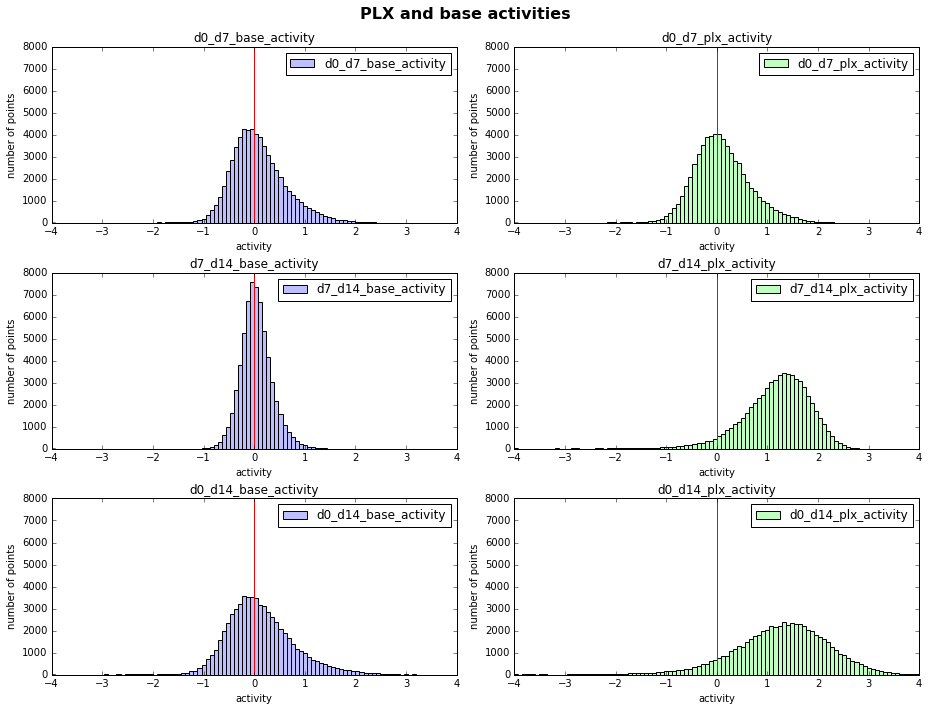

In [3]:
def plot_activity_w_lim(d1, d2, plx):
    plot_activity(d1, d2, plx, points)
    plt.ylim(0, 8000)
    plt.axvline(color='red')
    plt.legend()

with figure_grid(3, 2, 'PLX and base activities') as fig:
    fig.add_subplot(321); plot_activity_w_lim(0, 7, 'base')
    fig.add_subplot(322); plot_activity_w_lim(0, 7, 'plx')
    fig.add_subplot(323); plot_activity_w_lim(7, 14, 'base')
    fig.add_subplot(324); plot_activity_w_lim(7, 14, 'plx')
    fig.add_subplot(325); plot_activity_w_lim(0, 14, 'base')
    fig.add_subplot(326); plot_activity_w_lim(0, 14, 'plx')

In [4]:
d7_d14_base_activities = [p.d7_d14_base_activity() for p in points]

sigma, mean = numpy.std(d7_d14_base_activities), numpy.mean(d7_d14_base_activities)

print('average activity', mean)
print('standard deviation', sigma)

outside_d7_d14_range = lambda p: p.d0_d7_base_activity() > 3*sigma
inside_d7_d14_range = lambda p: p.d0_d7_base_activity() < -0.5*sigma

active_points = list(filter(outside_d7_d14_range, points))
inactive_points = list(filter(inside_d7_d14_range, points))

print('out of', len(points), 'points, approximately', len(active_points), 'are active')
print('out of', len(points), 'points, approximately', len(inactive_points), 'are inactive')

average activity 0.0374885138514
standard deviation 0.308318508294
out of 63815 points, approximately 5129 are active
out of 63815 points, approximately 22804 are inactive


In [5]:
active_point_genes = set([p.row['gene_name'] for p in active_points])

print('from the', len(active_points), 'active points, there are', len(active_point_genes), 'active genes')

has_active_point_gene = lambda p: p.row['gene_name'] in active_point_genes

same_gene_inactive_points = list(filter(has_active_point_gene, inactive_points))

print('there are', len(same_gene_inactive_points), 'inactive points on the same genes')

pctg = 100 * len(active_points + same_gene_inactive_points)/float(len(points))

print('new dataset is {}% of the original size'.format(round(pctg)))

from the 5129 active points, there are 3900 active genes
there are 3448 inactive points on the same genes
new dataset is 13% of the original size


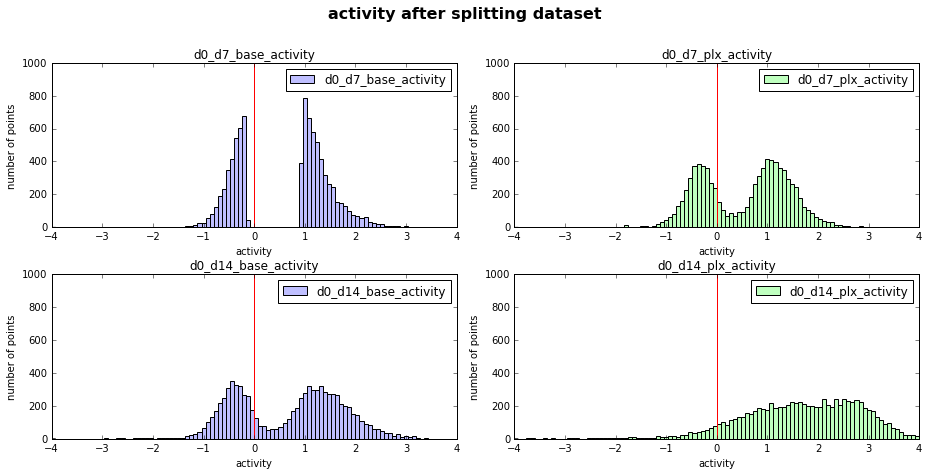

In [22]:
def plot_activity_w_lim(d1, d2, plx):
    plot_activity(d1, d2, plx, active_points + same_gene_inactive_points)
    plt.ylim(0, 1000)
    plt.axvline(color='red')
    plt.legend()

with figure_grid(2, 2, 'activity after splitting dataset') as fig:
    fig.add_subplot(221); plot_activity_w_lim(0, 7, 'base')
    fig.add_subplot(222); plot_activity_w_lim(0, 7, 'plx')
    fig.add_subplot(223); plot_activity_w_lim(0, 14, 'base')
    fig.add_subplot(224); plot_activity_w_lim(0, 14, 'plx')

In [7]:
def compare_by(feature, bins=20, xrng=None, subplot=None):
    compare_point_groups_by(feature, active_points, same_gene_inactive_points, bins=bins, xrng=xrng, axis1=subplot)

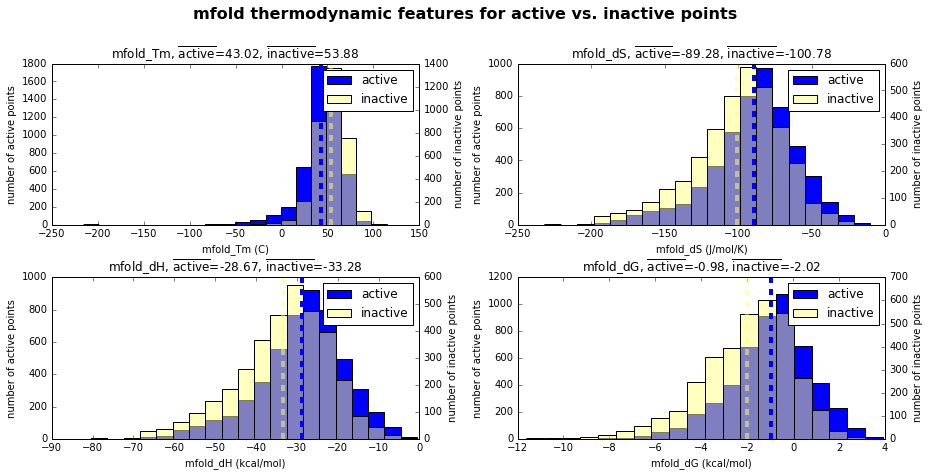

In [8]:
with figure_grid(2, 2, 'mfold thermodynamic features for active vs. inactive points') as fig:
    compare_by('mfold_Tm', subplot=fig.add_subplot(221))
    compare_by('mfold_dS', subplot=fig.add_subplot(222))
    compare_by('mfold_dH', subplot=fig.add_subplot(223))
    compare_by('mfold_dG', subplot=fig.add_subplot(224))

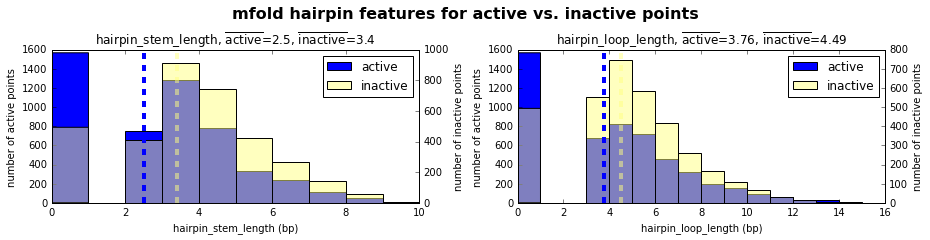

In [9]:
with figure_grid(1, 2, 'mfold hairpin features for active vs. inactive points') as fig:
    compare_by('hairpin_stem_length', bins=10, xrng=(0,10), subplot=fig.add_subplot(121))
    compare_by('hairpin_loop_length', bins=15, xrng=(0,15), subplot=fig.add_subplot(122))

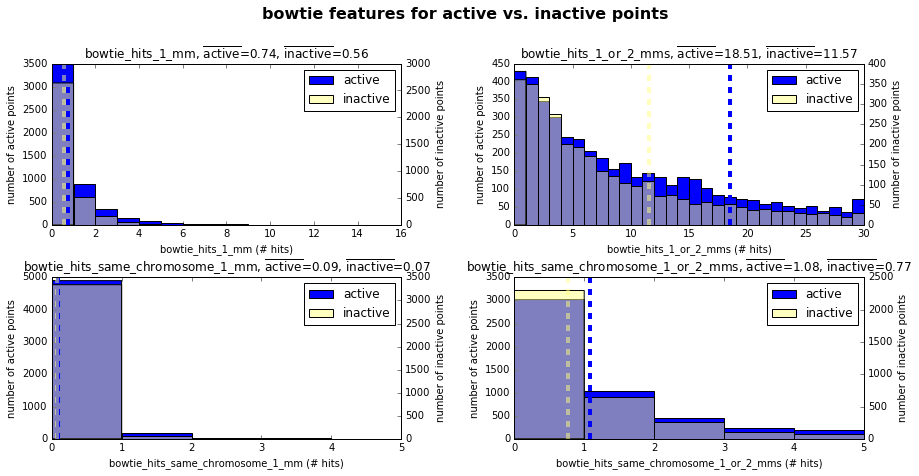

In [10]:
with figure_grid(2, 2, 'bowtie features for active vs. inactive points') as fig:
    compare_by('bowtie_hits_1_mm',                       bins=15, xrng=(0,15), subplot=fig.add_subplot(221))
    compare_by('bowtie_hits_1_or_2_mms',                 bins=30, xrng=(0,30), subplot=fig.add_subplot(222))
    compare_by('bowtie_hits_same_chromosome_1_mm',       bins=5,  xrng=(0,5),  subplot=fig.add_subplot(223))
    compare_by('bowtie_hits_same_chromosome_1_or_2_mms', bins=5,  xrng=(0,5),  subplot=fig.add_subplot(224))

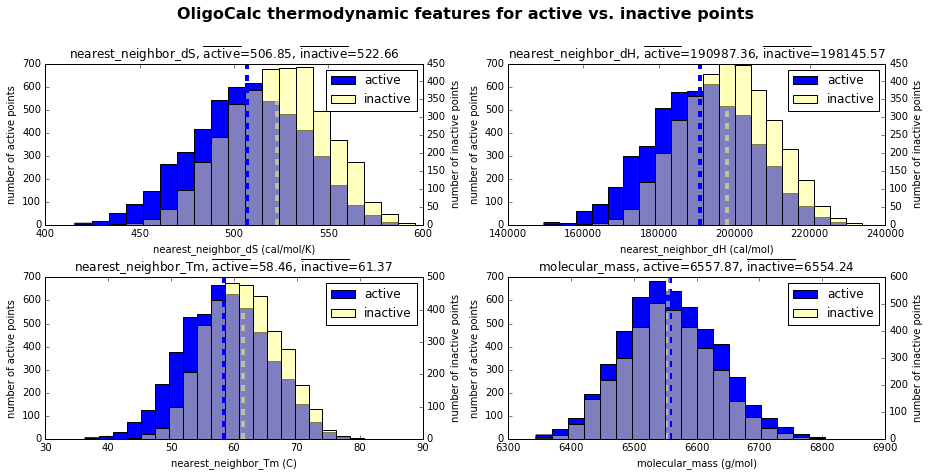

In [11]:
with figure_grid(2, 2, 'OligoCalc thermodynamic features for active vs. inactive points') as fig:
    compare_by('nearest_neighbor_dS', subplot=fig.add_subplot(221))
    compare_by('nearest_neighbor_dH', subplot=fig.add_subplot(222))
    compare_by('nearest_neighbor_Tm', subplot=fig.add_subplot(223))
    compare_by('molecular_mass', subplot=fig.add_subplot(224))

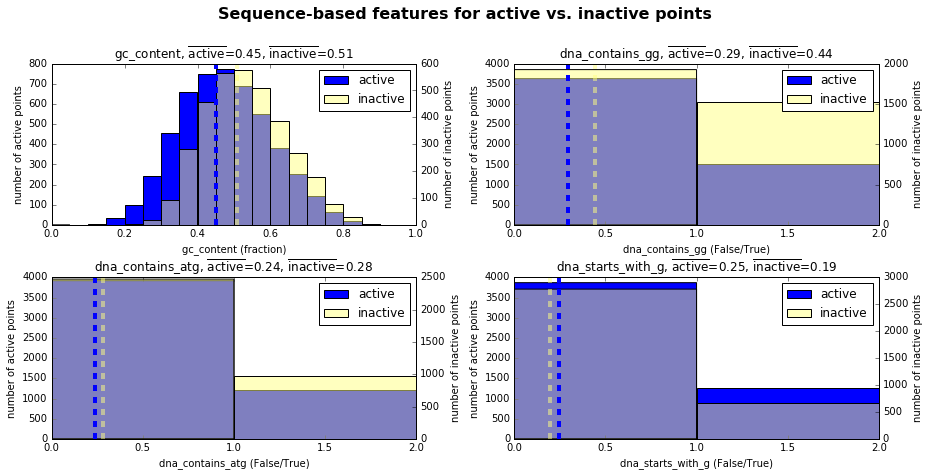

In [12]:
with figure_grid(2, 2, 'Sequence-based features for active vs. inactive points') as fig:
    compare_by('gc_content', xrng=(0,1), subplot=fig.add_subplot(221))
    compare_by('dna_contains_gg', bins=2, xrng=(0,2), subplot=fig.add_subplot(222))
    compare_by('dna_contains_atg', bins=2, xrng=(0,2), subplot=fig.add_subplot(223))
    compare_by('dna_starts_with_g', bins=2, xrng=(0,2), subplot=fig.add_subplot(224))

In [13]:
X = numpy.array([
   [p.mfold_dH(),
    p.dna_contains_gg(),
    p.hairpin_stem_length()] for p in active_points + same_gene_inactive_points])

y = numpy.array([1 for p in active_points] + [0 for p in same_gene_inactive_points]) 

print(X[0], 'is', y[0])

def training_test_split(X, y, fraction=0.9):
    n_examples = int(len(y) * fraction)
    indices = list(range(len(y)))
    random.shuffle(indices)
    X_train, y_train = X.take(indices[:n_examples], 0), y.take(indices[:n_examples])
    X_test, y_test = X.take(indices[n_examples:], 0), y.take(indices[n_examples:])
    return X_train, y_train, X_test, y_test

X_train, y_train, X_test, y_test = training_test_split(X, y)

print('training on', len(X_train), 'points, testing on', len(X_test))

tree = sklearn.ensemble.RandomForestClassifier(criterion='entropy')
tree.fit(X_train, y_train)
tree.score(X_test, y_test)

[-25.1   0.    0. ] is 1
training on 7719 points, testing on 858


0.61421911421911424